## Install and import

In [ ]:
!pip install sentencepiece
!pip install tf_sentencepiece
!pip install fastai==1.0.52

In [2]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *
import re
import sentencepiece as spm
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [3]:
drive._mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
path = Path(os.getcwd())
path = path/'gdrive'/'My Drive'
news=path/'Thesis Data'/'full doc csv'
aa=path/'Thesis Data'/'Our dataset'
aa2=path/'Thesis Data'/'AA dataset'
kfold16 = path/'Thesis Data'/'kfold'/'baad16'
kfold6 = path/'Thesis Data'/'kfold'/'baad6'

### BAAD6

In [5]:
baad6 = pd.concat([pd.read_csv(aa2/'ulm_train.csv'), pd.read_csv(aa2/'ulm_test.csv')]).reset_index(drop=True)
len(baad6)

2100

## Load sentence piece

In [6]:
vocab_size = 30000
model_prefix = news/'sp'

In [7]:
class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
        #post rules?
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)

In [8]:
mycust_tok = CustomTokenizer(SPTokenizer,model_prefix)

In [9]:
## load up the Processor
sp = spm.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')
itos = [] #{}
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos.append(line.split("\t")[0])
sp_vocab = Vocab(itos)
len(itos)

30000

## Utils

In [10]:
def testing(df, classifier):
  # df = pd.read_csv(dts) 
  text_array = df["text"].tolist()
  print(len(text_array))

  final_preds = []

  for text in text_array:
      preds = classifier.predict(text)
      final_preds.append(str(preds[0]))

  targets = df["label"].tolist()

  err=[]
  count =0;
  tst = len(text_array)

  for i in range(tst):
      if(targets[i]==final_preds[i]):
          count = count+1
      else:
  #         print(targets[i] + ", " + final_preds[i] + ';')
          err.append((targets[i],final_preds[i]))
  acc = count/tst
  print("Accuracy: ")
  print(acc)
  print(err)
  return final_preds, targets, err, acc

In [11]:
bs = 32
bptt = 70
moms = (0.8,0.7)

## BAAD6 K-fold

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
accuracies = []
f1_scores = []
predictions = []
targets = []
errors = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = skf.split(baad6[['text']], baad6[['label']])

In [14]:
# help(EarlyStoppingCallback)

In [15]:
def train_one_split(train_index, test_index, skip_first=False, min_grad_lr=None, force_lr=False):
  
  ## skip_first=True skips the first 6 epochs, and loads from saved model
  ## if skip_first=True, you need to give the previous learning rate (min_grad_lr) as a fall back for when automatic lr cannot be found
  ## if force_lr = True, use min_grad_lr

  X_train, X_test = baad6[['text']].loc[train_index], baad6[['text']].loc[test_index]
  y_train, y_test = baad6[['label']].loc[train_index], baad6[['label']].loc[test_index]
  train_df = pd.concat([X_train,y_train], axis=1)
  test_df = pd.concat([X_test,y_test], axis=1)

  train_df, valid_df = train_test_split(train_df, test_size=0.25, stratify=train_df['label'], random_state=666)
  ln_train = len(train_df)
  ln_valid = len(valid_df)
  ln_test = len(test_df)
  ln_total = ln_train + ln_valid + ln_test
  print("TRAIN len:", ln_train, "VALID len:", ln_valid, "TEST len:", ln_test, 
        "VALID percent:", np.round(ln_valid*100/ln_total,3),
        "TEST percent:", np.round(ln_test*100/ln_total,3))
  
  ## SET UP DATA
  data_clas = TextClasDataBunch.from_df(path=kfold6, train_df=train_df,valid_df=valid_df,
                                        tokenizer=mycust_tok,vocab=sp_vocab,bs=bs,text_cols='text',label_cols='label')
  learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
  
  ## TRAIN CLASSIFIER 10 EPOCHS
  if not skip_first:
    learn_cls.load_encoder(aa2/'models'/'bhai_AA_lm_subword_enc') ## model pre-trained on news dataset, then finetuned on AA dataset
    learn_cls.freeze()
    learn_cls.lr_find()
    learn_cls.recorder.plot(suggestion=True)
    min_grad_lr = learn_cls.recorder.min_grad_lr
    # min_grad_lr = 1.32E-06
    learn_cls.fit_one_cycle(2, min_grad_lr, moms=moms) # learn_cls.save('')

    learn_cls.freeze_to(-2)
    learn_cls.fit_one_cycle(2 , slice(min_grad_lr/(2.6**4),min_grad_lr), moms=moms)

    learn_cls.freeze_to(-3)
    learn_cls.fit_one_cycle(2 , slice(min_grad_lr/(2.6**4),min_grad_lr), moms=moms)
    learn_cls.save(kfold6/'kfold_baad6_6epochs')
    print("Saved 6 epoch checkpoint.")
    # return

  learn_cls.load(kfold6/'kfold_baad6_6epochs')
  print("Loaded 6 epoch checkpoint. The following epochs will follow early stopping mechanism, upto a maximum of 20 epochs.")
  learn_cls.unfreeze()
  if not force_lr:
    try:
      learn_cls.lr_find()
      learn_cls.recorder.plot(suggestion=True)
      min_grad_lr = learn_cls.recorder.min_grad_lr
    except:
      pass
  learn_cls.fit_one_cycle(20, slice(min_grad_lr/(2.6**4),min_grad_lr), moms=moms, 
                          callbacks=[EarlyStoppingCallback(learn_cls, monitor='accuracy', patience=2, min_delta=0.0001)]
                          )

  ## TESTING
  preds, targs, err, acc = testing(test_df, learn_cls)
  f1 = f1_score(targs, preds, average='weighted')

  ## SAVING RESULTS
  accuracies.append(acc)
  f1_scores.append(f1)
  predictions.append(preds)
  targets.append(targs)
  errors.append(err)

  print(acc, f1)

TRAIN len: 1260 VALID len: 420 TEST len: 420 VALID percent: 20.0 TEST percent: 20.0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.704089,0.515023,0.919048,03:13
1,0.436563,0.255535,0.935714,03:05


epoch,train_loss,valid_loss,accuracy,time
0,0.267281,0.215641,0.938095,03:30
1,0.226992,0.211769,0.935714,03:31


epoch,train_loss,valid_loss,accuracy,time
0,0.186172,0.246307,0.921429,04:20
1,0.165624,0.181300,0.945238,04:01


Saved 6 epoch checkpoint.
Loaded 6 epoch checkpoint. The following epochs will follow early stopping mechanism, upto a maximum of 20 epochs.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06


epoch,train_loss,valid_loss,accuracy,time
0,0.095296,0.176654,0.950000,05:01
1,0.100293,0.180020,0.945238,04:46
2,0.088982,0.182158,0.945238,04:49


Epoch 3: early stopping
420
Accuracy: 
0.9476190476190476
[('rn', 'ij'), ('fe', 'mk'), ('mk', 'rn'), ('rg', 'rn'), ('rg', 'mk'), ('rg', 'rn'), ('hm', 'rn'), ('mk', 'hm'), ('mk', 'hm'), ('rg', 'fe'), ('rg', 'mk'), ('ij', 'fe'), ('hm', 'fe'), ('rn', 'mk'), ('rn', 'fe'), ('fe', 'ij'), ('rg', 'rn'), ('mk', 'fe'), ('mk', 'fe'), ('hm', 'rg'), ('mk', 'rn'), ('ij', 'rn')]
0.9476190476190476 0.9476902880731992


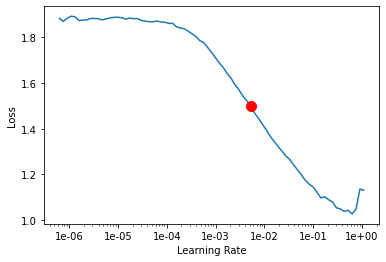

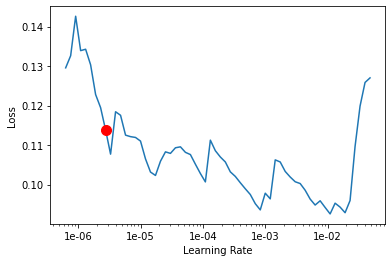

In [ ]:
## 1
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

TRAIN len: 1260 VALID len: 420 TEST len: 420 VALID percent: 20.0 TEST percent: 20.0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.742074,0.549212,0.907143,03:25
1,0.467829,0.272806,0.926190,03:11


epoch,train_loss,valid_loss,accuracy,time
0,0.271911,0.211301,0.940476,03:36
1,0.231220,0.172882,0.945238,03:22


epoch,train_loss,valid_loss,accuracy,time
0,0.192436,0.150708,0.954762,04:18
1,0.151072,0.145405,0.952381,04:06


Saved 6 epoch checkpoint.
Loaded 6 epoch checkpoint. The following epochs will follow early stopping mechanism, upto a maximum of 20 epochs.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06


epoch,train_loss,valid_loss,accuracy,time
0,0.093835,0.152868,0.947619,05:16
1,0.101222,0.148593,0.957143,04:54
2,0.096645,0.150777,0.952381,04:53
3,0.097253,0.150639,0.952381,05:13


Epoch 4: early stopping
420
Accuracy: 
0.95
[('fe', 'rg'), ('rn', 'rg'), ('rg', 'rn'), ('ij', 'hm'), ('ij', 'rn'), ('fe', 'ij'), ('rg', 'rn'), ('mk', 'rg'), ('rn', 'rg'), ('ij', 'rn'), ('mk', 'ij'), ('hm', 'mk'), ('rg', 'hm'), ('rn', 'mk'), ('fe', 'ij'), ('ij', 'rn'), ('mk', 'rg'), ('rn', 'rg'), ('rn', 'mk'), ('rg', 'ij'), ('rg', 'rn')]
0.95 0.9501328708736692


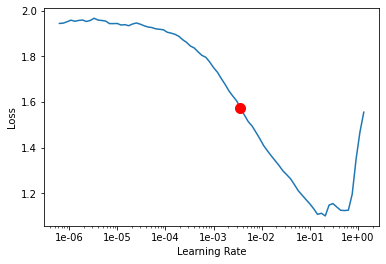

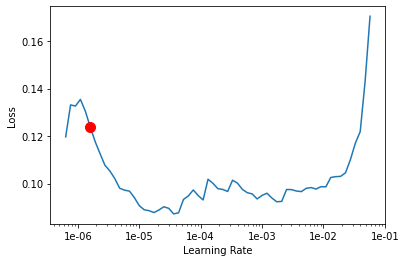

In [ ]:
## 2
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

TRAIN len: 1260 VALID len: 420 TEST len: 420 VALID percent: 20.0 TEST percent: 20.0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.710181,0.540552,0.885714,03:09
1,0.400796,0.298584,0.921429,03:21


epoch,train_loss,valid_loss,accuracy,time
0,0.255355,0.303835,0.923810,03:45
1,0.212124,0.276972,0.916667,03:26


epoch,train_loss,valid_loss,accuracy,time
0,0.128297,0.283188,0.921429,04:38
1,0.136062,0.254667,0.923810,04:15


Saved 6 epoch checkpoint.
Loaded 6 epoch checkpoint. The following epochs will follow early stopping mechanism, upto a maximum of 20 epochs.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


epoch,train_loss,valid_loss,accuracy,time
0,0.070358,0.245974,0.928571,05:10
1,0.081669,0.245664,0.923810,04:54
2,0.079113,0.242862,0.928571,05:20


Epoch 3: early stopping
420
Accuracy: 
0.9642857142857143
[('hm', 'mk'), ('rn', 'mk'), ('mk', 'rn'), ('fe', 'mk'), ('mk', 'fe'), ('fe', 'mk'), ('fe', 'mk'), ('rg', 'fe'), ('hm', 'mk'), ('rg', 'rn'), ('rn', 'rg'), ('rn', 'ij'), ('rn', 'mk'), ('mk', 'fe'), ('fe', 'ij')]
0.9642857142857143 0.9644262646628972


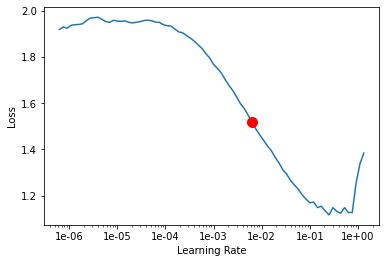

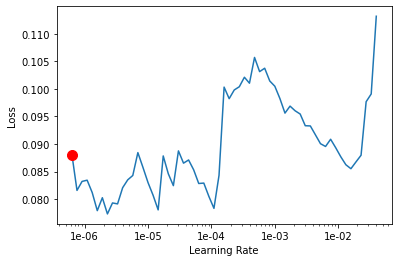

In [ ]:
## 3
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

TRAIN len: 1260 VALID len: 420 TEST len: 420 VALID percent: 20.0 TEST percent: 20.0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.750592,0.593659,0.909524,03:11
1,0.441195,0.310421,0.919048,02:57


epoch,train_loss,valid_loss,accuracy,time
0,0.285161,0.247409,0.935714,03:29
1,0.217102,0.224169,0.928571,03:07


epoch,train_loss,valid_loss,accuracy,time
0,0.167106,0.240647,0.930952,04:02
1,0.134107,0.215705,0.938095,04:01


Saved 6 epoch checkpoint.
Loaded 6 epoch checkpoint. The following epochs will follow early stopping mechanism, upto a maximum of 20 epochs.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06


epoch,train_loss,valid_loss,accuracy,time
0,0.086598,0.209303,0.938095,04:43
1,0.088679,0.211167,0.938095,04:34
2,0.080330,0.215509,0.940476,04:50
3,0.081406,0.214672,0.938095,04:27
4,0.084943,0.216059,0.938095,04:37


Epoch 5: early stopping
420
Accuracy: 
0.95
[('rn', 'ij'), ('ij', 'mk'), ('mk', 'fe'), ('rg', 'rn'), ('rg', 'mk'), ('ij', 'rn'), ('ij', 'hm'), ('rg', 'fe'), ('rg', 'fe'), ('fe', 'mk'), ('ij', 'hm'), ('rg', 'fe'), ('rg', 'rn'), ('mk', 'fe'), ('rn', 'hm'), ('fe', 'mk'), ('fe', 'rn'), ('rg', 'mk'), ('ij', 'rn'), ('fe', 'mk'), ('rn', 'mk')]
0.95 0.9500058286824148


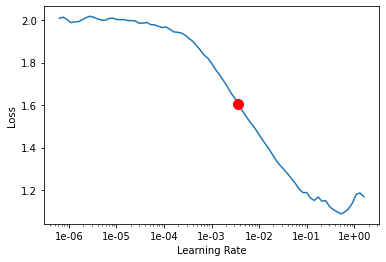

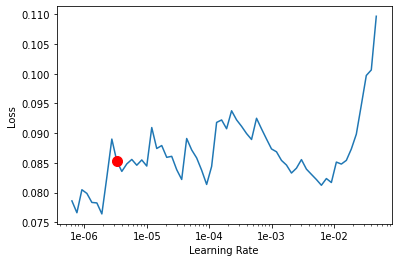

In [16]:
## 4
train_index, test_index = next(splits)
train_index, test_index = next(splits)
train_index, test_index = next(splits)
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

TRAIN len: 1260 VALID len: 420 TEST len: 420 VALID percent: 20.0 TEST percent: 20.0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.706351,0.468800,0.930952,03:03
1,0.416379,0.263821,0.942857,02:52


epoch,train_loss,valid_loss,accuracy,time
0,0.309159,0.288712,0.909524,03:17
1,0.227059,0.236168,0.921429,03:06


epoch,train_loss,valid_loss,accuracy,time
0,0.150511,0.235448,0.930952,04:14
1,0.139241,0.201581,0.945238,03:57


Saved 6 epoch checkpoint.
Loaded 6 epoch checkpoint. The following epochs will follow early stopping mechanism, upto a maximum of 20 epochs.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06


epoch,train_loss,valid_loss,accuracy,time
0,0.096037,0.190171,0.947619,04:46
1,0.091181,0.198397,0.942857,04:56
2,0.095988,0.209864,0.933333,04:53


Epoch 3: early stopping
420
Accuracy: 
0.9404761904761905
[('rn', 'hm'), ('rg', 'rn'), ('rg', 'hm'), ('rg', 'fe'), ('hm', 'mk'), ('fe', 'ij'), ('fe', 'rg'), ('rg', 'rn'), ('fe', 'mk'), ('mk', 'rg'), ('hm', 'ij'), ('rg', 'mk'), ('mk', 'rn'), ('mk', 'hm'), ('rg', 'rn'), ('mk', 'rg'), ('mk', 'rn'), ('fe', 'rg'), ('rg', 'hm'), ('fe', 'rn'), ('hm', 'mk'), ('rg', 'mk'), ('hm', 'mk'), ('fe', 'mk'), ('rn', 'mk')]
0.9404761904761905 0.9403701405634574


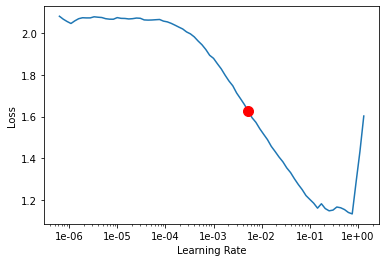

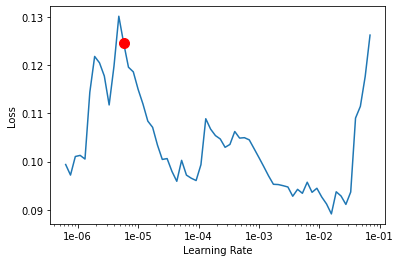

In [17]:
## 5
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

In [18]:
accuracies = [0.9476190476190476, 0.95, 0.9642857142857143, 0.95, 0.9404761904761905]
f1_scores = [0.9476902880731992, 0.9501328708736692, 0.9644262646628972, 0.9500058286824148, 0.9403701405634574]

In [19]:
np.array(accuracies).mean(), np.array(f1_scores).mean()

(0.9504761904761905, 0.9505250785711274)